In [1]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
os.chdir("drive/MyDrive")
import numpy as np
import pickle
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D
from keras.losses import CategoricalCrossentropy
from keras import Sequential
from sklearn.metrics import accuracy_score,classification_report
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam,Adagrad,SGD,RMSprop
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

## Reading Data from Pickle Files

In [2]:
pickle_file_link = "data"
X_train = pickle.load(open(f"{pickle_file_link}/X_train.pickle","rb")).reshape(-1,64,64,1)
y_train = pickle.load(open(f"{pickle_file_link}/y_train.pickle","rb"))

X_test = pickle.load(open(f"{pickle_file_link}/X_test.pickle","rb")).reshape(-1,64,64,1)
y_test = pickle.load(open(f"{pickle_file_link}/y_test.pickle","rb"))

X_val = pickle.load(open(f"{pickle_file_link}/X_val.pickle","rb")).reshape(-1,64,64,1)
y_val = pickle.load(open(f"{pickle_file_link}/y_val.pickle","rb"))

In [3]:
print(f"X train shape : {X_train.shape}")
print(f"X val shape : {X_val.shape}")
print(f"X test shape : {X_test.shape}")

X train shape : (6985, 64, 64, 1)
X val shape : (873, 64, 64, 1)
X test shape : (874, 64, 64, 1)


## Tuning Neural Network Layers

In [4]:
def tune_layers(filter1,filter2,unit_1, unit_2):
    filter1 = round(filter1)
    filter2 = round(filter2)
    unit_1 = round(unit_1)
    unit_2 = round(unit_2)

    def get_nn():
        nn = Sequential()
        nn.add(Conv2D(filter1, (3,3),input_shape=(64,64,1), activation='relu'))
        nn.add(MaxPool2D((2,2)))
        nn.add(Conv2D(filter2, (3,3), activation='relu'))
        nn.add(MaxPool2D((2,2)))
        nn.add(Flatten())
        nn.add(Dense(unit_1, activation='relu'))
        nn.add(Dense(unit_2, activation='relu'))
        nn.add(Dense(10, activation="softmax"))
        nn.compile(loss=CategoricalCrossentropy(from_logits=False),
                   optimizer="adam", metrics=["accuracy"])
        return nn

    score = 0
    nn = get_nn()
    nn.fit(X_train,y_train,epochs=15,batch_size=256,verbose=0)
    y_pred = nn.predict(X_val)
    return accuracy_score(y_val.argmax(axis=1),y_pred.argmax(axis=1))

In [5]:
params_layer = {
    "unit_1":(256,512),
    "unit_2":(64,256),
    "filter1":(16,64),
    "filter2":(16,64)
}

"""
    BayesianOptimization : verilen parametre aralıklarını deneyerek 
    gridsearch ya da randomizedgridsearch'e göre daha hızlı bir şekilde en iyi parametleri bulur.
"""

optimizer = BayesianOptimization(tune_layers,params_layer,random_state=34)
optimizer.maximize()
print(optimizer.max)

|   iter    |  target   |  filter1  |  filter2  |  unit_1   |  unit_2   |
-------------------------------------------------------------------------
|  1        |  0.8465   |  17.85    |  53.44    |  279.7    |  185.5    |
|  2        |  0.8511   |  16.67    |  60.94    |  365.2    |  112.6    |
|  3        |  0.8247   |  25.12    |  35.91    |  259.4    |  188.5    |
|  4        |  0.8603   |  57.73    |  45.23    |  462.8    |  222.7    |
|  5        |  0.8316   |  29.04    |  56.15    |  328.3    |  90.56    |
|  6        |  0.8625   |  59.91    |  46.35    |  462.3    |  223.3    |
|  7        |  0.8694   |  64.0     |  54.93    |  446.3    |  230.8    |
|  8        |  0.8809   |  64.0     |  64.0     |  464.1    |  252.6    |
|  9        |  0.8648   |  53.27    |  57.87    |  498.6    |  255.9    |
|  10       |  0.8843   |  64.0     |  64.0     |  408.7    |  256.0    |
|  11       |  0.8637   |  64.0     |  64.0     |  363.1    |  256.0    |
|  12       |  0.8625   |  23.35    | 

## Tuning Optimizer and Learning Rate

In [6]:
def tune_opt_lr(opt,lr):
    opts = [Adam,Adagrad,SGD,RMSprop]
    opt = round(opt) 

    def get_nn():
        nn = Sequential()
        nn.add(Conv2D(41, (3,3),input_shape=(64,64,1), activation='relu'))
        nn.add(MaxPool2D((2,2)))
        nn.add(Conv2D(64, (3,3), activation='relu'))
        nn.add(MaxPool2D((2,2)))
        nn.add(Flatten())
        nn.add(Dense(457, activation='relu'))
        nn.add(Dense(256, activation='relu'))
        nn.add(Dense(10, activation="softmax"))
        nn.compile(loss=CategoricalCrossentropy(from_logits=False),
                   optimizer=opts[opt](learning_rate=lr), metrics=["accuracy"])
        return nn

    score = 0
    nn = get_nn()
    nn.fit(X_train,y_train,epochs=15,batch_size=256,verbose=0)
    y_pred = nn.predict(X_val)
    return accuracy_score(y_val.argmax(axis=1),y_pred.argmax(axis=1))

In [7]:
params_opt_lr = {
    "opt":(0,3),
    "lr":(0.0005,0.001)
}


optimizer = BayesianOptimization(tune_opt_lr,params_opt_lr,random_state=34)
optimizer.maximize()
print(optimizer.max)

|   iter    |  target   |    lr     |    opt    |
-------------------------------------------------
|  1        |  0.1615   |  0.000519 |  2.34     |
|  2        |  0.1856   |  0.000546 |  1.899    |
|  3        |  0.8053   |  0.000506 |  2.808    |
|  4        |  0.1775   |  0.000713 |  0.7593   |
|  5        |  0.1535   |  0.000595 |  1.244    |
|  6        |  0.8637   |  0.000723 |  0.105    |
|  7        |  0.8694   |  0.000852 |  0.1049   |
|  8        |  0.8614   |  0.000893 |  0.09117  |
|  9        |  0.7973   |  0.000934 |  2.831    |
|  10       |  0.7801   |  0.001    |  2.781    |
|  11       |  0.7927   |  0.0005   |  2.86     |
|  12       |  0.8477   |  0.001    |  2.889    |
|  13       |  0.7721   |  0.0005   |  2.917    |
|  14       |  0.8385   |  0.000814 |  2.748    |
|  15       |  0.8568   |  0.000866 |  2.719    |
|  16       |  0.7812   |  0.0005   |  2.69     |
|  17       |  0.7812   |  0.000891 |  2.653    |
|  18       |  0.8648   |  0.000975 |  2.619    |


## Tuning Batch Size

In [8]:
def tune_batch_size(batch_size):
    batch_size = int(batch_size)

    def get_nn():
        nn = Sequential()
        nn.add(Conv2D(41, (3,3),input_shape=(64,64,1), activation='relu'))
        nn.add(MaxPool2D((2,2)))
        nn.add(Conv2D(64, (3,3), activation='relu'))
        nn.add(MaxPool2D((2,2)))
        nn.add(Flatten())
        nn.add(Dense(457, activation='relu'))
        nn.add(Dense(256, activation='relu'))
        nn.add(Dense(10, activation="softmax"))
        nn.compile(loss=CategoricalCrossentropy(from_logits=False),
                   optimizer=RMSprop(learning_rate=0.001), metrics=["accuracy"])
        return nn

    score = 0
    nn = get_nn()
    nn.fit(X_train,y_train,epochs=15,batch_size=batch_size,verbose=0)
    y_pred = nn.predict(X_val)
    return accuracy_score(y_val.argmax(axis=1),y_pred.argmax(axis=1))

In [9]:
params_batch_size = {
    "batch_size":(64,512)
}


optimizer = BayesianOptimization(tune_batch_size,params_batch_size,random_state=34)
optimizer.maximize(n_iter=10)
print(optimizer.max)

|   iter    |  target   | batch_... |
-------------------------------------
|  1        |  0.8832   |  81.28    |
|  2        |  0.803    |  413.5    |
|  3        |  0.8866   |  105.5    |
|  4        |  0.7457   |  347.5    |
|  5        |  0.874    |  70.22    |
|  6        |  0.8007   |  512.0    |
|  7        |  0.8603   |  104.2    |
|  8        |  0.8648   |  109.3    |
|  9        |  0.8683   |  76.37    |
|  10       |  0.8729   |  86.16    |
|  11       |  0.8877   |  64.46    |
|  12       |  0.8751   |  92.4     |
|  13       |  0.8797   |  191.5    |
|  14       |  0.8717   |  196.8    |
|  15       |  0.8683   |  186.0    |
{'target': 0.8877434135166093, 'params': {'batch_size': 64.460991581886}}


## Tuning Epoch

In [10]:
def get_nn():
        nn = Sequential()
        nn.add(Conv2D(41, (3,3),input_shape=(64,64,1), activation='relu'))
        nn.add(MaxPool2D((2,2)))
        nn.add(Conv2D(64, (3,3), activation='relu'))
        nn.add(MaxPool2D((2,2)))
        nn.add(Flatten())
        nn.add(Dense(457, activation='relu'))
        nn.add(Dense(256, activation='relu'))
        nn.add(Dense(10, activation="softmax"))
        nn.compile(loss=CategoricalCrossentropy(from_logits=False),
                   optimizer=RMSprop(learning_rate=0.001), metrics=["accuracy"])
        return nn

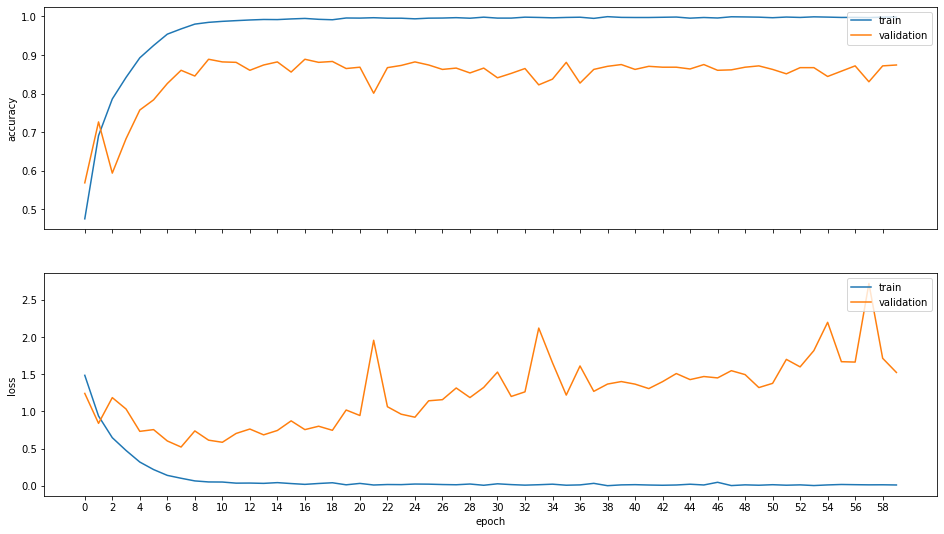

In [11]:
model = get_nn()
history = model.fit(X_train,y_train,batch_size=64,epochs=60,validation_data=(X_val,y_val),verbose=0)


fig, (ax1, ax2) = plt.subplots(2,sharex="all",figsize=(16,9))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper right')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xticks(np.arange(0, 60, 2))
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper right')
plt.show()

## Final Model

In [12]:
nn = get_nn()
history = nn.fit(X_train,y_train,batch_size=68,epochs=16,validation_data=(X_val,y_val))

Epoch 1/16
103/103 [==============================] - 3s 18ms/step - loss: 1.4919 - accuracy: 0.4686 - val_loss: 1.1018 - val_accuracy: 0.6094
Epoch 2/16
103/103 [==============================] - 2s 15ms/step - loss: 0.9057 - accuracy: 0.6976 - val_loss: 0.7429 - val_accuracy: 0.7514
Epoch 3/16
103/103 [==============================] - 2s 16ms/step - loss: 0.6369 - accuracy: 0.7874 - val_loss: 0.6899 - val_accuracy: 0.7675
Epoch 4/16
103/103 [==============================] - 2s 15ms/step - loss: 0.4405 - accuracy: 0.8541 - val_loss: 0.5925 - val_accuracy: 0.8167
Epoch 5/16
103/103 [==============================] - 2s 15ms/step - loss: 0.2966 - accuracy: 0.8982 - val_loss: 0.7914 - val_accuracy: 0.7743
Epoch 6/16
103/103 [==============================] - 2s 15ms/step - loss: 0.2092 - accuracy: 0.9291 - val_loss: 0.5049 - val_accuracy: 0.8488
Epoch 7/16
103/103 [==============================] - 2s 15ms/step - loss: 0.1375 - accuracy: 0.9573 - val_loss: 0.6643 - val_accuracy: 0.8179

## Performance Evaluation

In [13]:
predictions = nn.predict(X_test)
print(f"""Test Result : \n{classification_report(y_test.argmax(axis=1),
                                               predictions.argmax(axis=1),target_names=[str(x) for x in range(10)])}""")

Test Result : 
              precision    recall  f1-score   support

           0       0.83      0.92      0.88        99
           1       0.98      0.94      0.96        51
           2       0.69      0.74      0.71        91
           3       0.91      0.88      0.89       104
           4       0.96      0.80      0.87       112
           5       0.83      0.97      0.90        94
           6       0.93      0.87      0.90        30
           7       0.93      0.83      0.88       100
           8       0.87      0.96      0.91        83
           9       0.82      0.80      0.81       110

    accuracy                           0.86       874
   macro avg       0.88      0.87      0.87       874
weighted avg       0.87      0.86      0.86       874



## Predictions

In [14]:
for i in range(1, 10):
    idx = np.random.randint(0,len(y_test),size=1)
    print(f"{idx[0]}.th image real class : {y_test[idx].argmax()}")
    print(f"Prediction : {nn.predict(X_test[idx]).argmax()} with {nn.predict(X_test[idx]).max()} probability %\n")

653.th image real class : 2
Prediction : 2 with 1.0 probability %

448.th image real class : 7
Prediction : 7 with 0.9999912977218628 probability %

384.th image real class : 0
Prediction : 0 with 1.0 probability %

556.th image real class : 0
Prediction : 0 with 0.9999997615814209 probability %

763.th image real class : 3
Prediction : 3 with 1.0 probability %

817.th image real class : 9
Prediction : 9 with 0.9999996423721313 probability %

655.th image real class : 0
Prediction : 0 with 0.9999979734420776 probability %

110.th image real class : 7
Prediction : 7 with 1.0 probability %

665.th image real class : 4
Prediction : 4 with 1.0 probability %

